In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
import warnings
warnings.filterwarnings("ignore")


먼저, 우리는 Scikit-Learn의 Isolation Forest 알고리즘을 사용하여 예제를 만들어 알고리즘의 대략적인 흐름과 결과를 살펴보겠습니다. 이상 감지 도구는 여러 가지가 있지만, 이번에는 다음과 같은 도구를 사용하여 실험을 진행하려고 합니다.

PyOD: 클래식 모델부터 딥 러닝 모델까지 총 30가지 이상의 알고리즘을 제공하며, Scikit-Learn과 유사한 사용법을 가지고 있습니다.

Scikit-Learn: 4가지 일반적인 알고리즘을 포함하고 있으며, 간단하고 사용하기 쉽습니다.

TODS: PyOD와 유사한 방식으로 다양한 시계열 이상 감지 알고리즘을 제공합니다.

데이터셋은 월별 급여 데이터이며, 단위는 만원입니다. 어떤 값이 이상치인지 확인해보겠습니다.

In [3]:
# 필요한 라이브러리 불러오기
import numpy   as np
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 일부 이상치를 넣어서 급여 데이터를 만들어보겠습니다.
df = pd.DataFrame({'salary':[4,1,4,5,3,6,2,5,6,2,5,7,1,8,12,33,4,7,6,7,8,55]})

#모델 설정
model = IsolationForest(n_estimators=100, 
                      max_samples='auto', 
                      contamination=float(0.1),
                      max_features=1.0,
                       random_state = 1004)
# 모델 훈련
model.fit(df[['salary']])

# decision_function을 통해 이상 점수를 얻을 수 있습니다
df['scores']  = model.decision_function(df[['salary']])

# predict() 함수를 사용하면 모델의 이상 여부 판단을 얻을 수 있습니다. -1은 이상치를 나타내고, 1은 정상을 나타냅니다.
df['anomaly'] = model.predict(df[['salary']])
print(df)

    salary    scores  anomaly
0        4  0.194431        1
1        1  0.097424        1
2        4  0.194431        1
3        5  0.226778        1
4        3  0.141024        1
5        6  0.222908        1
6        2  0.151436        1
7        5  0.226778        1
8        6  0.222908        1
9        2  0.151436        1
10       5  0.226778        1
11       7  0.206867        1
12       1  0.097424        1
13       8  0.179884        1
14      12 -0.010825       -1
15      33 -0.117029       -1
16       4  0.194431        1
17       7  0.206867        1
18       6  0.222908        1
19       7  0.206867        1
20       8  0.179884        1
21      55 -0.191967       -1


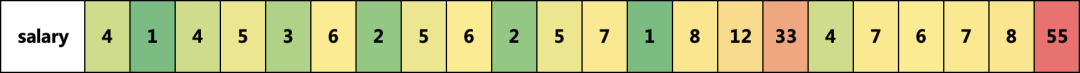

> #### 우리는 세 개의 이상치 데이터가 식별되었음을 확인할 수 있습니다. 이는 우리의 이해와 일치합니다. 이상치 값이 클수록 이상치 점수도 커집니다. 예를 들어, 월급이 55만인 개인은 변칙적인 값이거나 데이터 오류가 있을 수 있습니다.

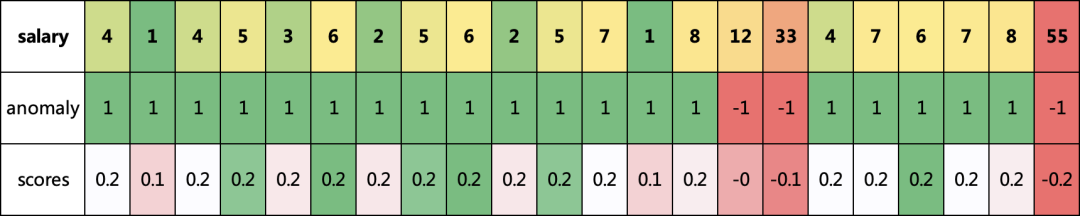


Isolation Forest 알고리즘을 이해하려면, 일단 이름에서부터 시작해보는 것이 좋습니다. 이 알고리즘의 이름은 '고립된 숲(Isolation Forest)'인데, 이것을 통해 알 수 있듯, 이 알고리즘은 데이터를 '숲'으로 생각하고, 이상치를 '고립된 나무'로 비유합니다.

우리는 숲을 걷는 상상을 해봅시다. 숲속에서 눈을 가린 채로 걸어다닐 때, 대부분의 나무는 서로 가깝게 있기 때문에 그들을 발견하는 데 오랜 시간이 걸릴 것입니다. 그러나 고립된 나무(이상치)는 주변에 다른 나무가 없기 때문에 빠르게 발견할 수 있습니다. 

이상치를 고립된 나무로 생각하는 것이 중요한 이유는, 이렇게 생각하면 이상치를 찾는 데 필요한 단계의 수를 측정하는 것이 자연스럽기 때문입니다. 이것이 바로 Isolation Forest가 이상치를 탐지하는 방식입니다. 

이제 이 알고리즘이 어떻게 동작하는지 보겠습니다.

1. **나무 생성:** 데이터를 분리하기 위해 Isolation Tree라는 특수한 나무를 만듭니다. 이 과정에서는 랜덤으로 특성을 선택하고 그 특성의 최소와 최대 값 사이의 랜덤한 값을 분할 값으로 사용하여 데이터를 분할합니다. 이런 식으로 서브셋이 더 이상 분할할 수 없거나, 나무가 지정된 최대 깊이에 도달할 때까지 계속 분할합니다.

2. **평균 경로 길이 계산:** 분리된 각 데이터 포인트까지의 경로 길이를 계산합니다. 이상치는 주변에 비슷한 데이터가 없기 때문에 일반적으로 더 짧은 경로 길이로 분리됩니다.

3. **이상치 점수 계산:** 각 나무에서 계산된 평균 경로 길이를 이용하여 이상치 점수를 계산합니다. 이상치 점수는 0과 1 사이의 값으로, 이 값이 클수록 해당 데이터 포인트가 이상치일 확률이 높다는 것을 의미합니다. 이 점수는 다음 공식을 통해 계산

됩니다:

S(x, n) = 2^(-(E(h(x))/c(n)))

여기서 E(h(x))는 샘플 x의 평균 경로 길이(h(x))의 평균이고, c(n)은 n개의 샘플을 가진 이진 탐색 트리의 평균 경로 길이입니다.

이 공식을 통해 계산된 이상치 점수를 이용하여 이상치를 판별합니다. 점수가 임계값보다 큰 데이터 포인트는 이상치로 분류합니다.

Isolation Forest 알고리즘은 이런 식으로 높은 차원의 데이터에서도 효과적으로 이상치를 탐지할 수 있습니다. 고립된 나무를 찾는 방법과 이를 이용한 점수 계산 방식은 이 알고리즘의 핵심입니다. 이것이 Isolation Forest 알고리즘을 통해 이상치를 어떻게 찾아내는지에 대한 설명입니다.

Isolation Forest 알고리즘의 개념을 설명하기 위한 추가 예시로서, 다음과 같이 풀어볼 수 있습니다.

이 예시에서는 일련의 1차원 데이터가 주어졌다고 가정해봅시다. 이 데이터 안에는 A와 B라는 두 개의 데이터 포인트가 있습니다. 우리의 목표는 이 두 데이터 포인트를 다른 데이터들로부터 분리하는 것입니다.

그럼 어떻게 이것을 할 수 있을까요? 우리는 데이터의 최대값과 최소값 사이에서 임의의 값 X를 선택하고, 이 값 X를 기준으로 데이터를 두 그룹(<X 와 >=X)으로 분리합니다. 그 다음 이 두 그룹을 또 다시 같은 방법으로 분리하고, 이런 식으로 계속해서 데이터를 분리해 나갑니다. 이렇게 하면서 데이터가 더 이상 분리되지 않을 때까지 계속합니다.

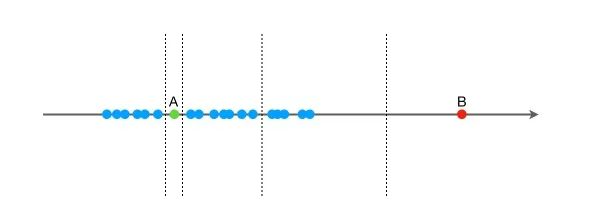

이 과정에서 주목할 점은, B는 다른 데이터로부터 비교적 멀리 떨어져 있기 때문에 이를 분리하는 데 필요한 분리 횟수가 매우 적다는 것입니다. 반면에 A는 다른 데이터 포인트와 군집을 이루고 있으므로, A를 분리하는 데는 많은 분리 횟수가 필요합니다.

이런 방식으로 Isolation Forest 알고리즘은 분리 횟수를 통해 데이터 포인트가 군집에 속해 있는지(정상), 아니면 고립되어 있는지(이상치)를 판별합니다. 즉, 분리 횟수가 적을수록 데이터 포인트는 이상치일 가능성이 높고, 분리 횟수가 많을수록 데이터 포인트는 정상 데이터일 가능성이 높습니다.

이것이 바로 Isolation Forest 알고리즘이 이상치를 어떻게 찾아내는지에 대한 간단한 예시입니다. 이러한 방법을 통해 Isolation Forest는 높은 차원의 데이터에서도 효과적으로 이상치를 탐지할 수 있습니다. 이상치를 고립된 나무로 생각하고, 분리 횟수를 이용하여 이상치를 판별하는 방식이 이 알고리즘의 핵심입니다.

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 파라미터 상세 내용:</font></h3>

**매개변수 설명:**

- <font color='#2E8B57'>n_estimators</font>: int, optional (default=100)
    - iTree의 개수로, 생성되는 랜덤 트리의 수를 지정합니다. 기본값은 100개입니다.

- <font color='#2E8B57'>max_samples</font>: int or float, optional (default="auto")
    - 서브트리를 구성하는 샘플의 수입니다. 정수는 개수를, 소수는 전체 집합에서의 비율을 나타냅니다.
    - 랜덤 트리를 훈련시키기 위해 사용되는 샘플 수, 즉 서브 샘플링의 크기입니다.
    - 정수로 설정하면, 총 샘플 X에서 max_samples개의 샘플을 가져와 하나의 트리 iTree를 생성합니다.
    - 부동소수점으로 설정하면, 총 샘플 X에서 max_samples * X.shape[0]개의 샘플을 가져옵니다. 여기서 X.shape[0]은 전체 샘플의 개수를 의미합니다.
    - "auto"로 설정하면, max_samples=min(256, n_samples)이며, n_samples는 전체 샘플의 수입니다. max_samples 값이 제공된 전체 샘플 수보다 큰 경우, 모든 샘플이 사용되며, 즉 샘플링 없이 n_estimators개의 iTree가 동일한 샘플을 사용하여 구성됩니다.

- <font color='#2E8B57'>contamination</font>: float in (0., 0.5), optional (default=0.1)
    - (0., 0.5) 범위에서 설정되며, 주어진 데이터 세트에서 이상 데이터의 비율을 나타냅니다. 훈련 데이터에서 이상 데이터의 수를 의미합니다.
    - 데이터 세트의 이상치 비율을 정의하는 매개변수입니다. 이 매개변수 값을 정의하는 것은 결정 함수에서 임계값을 정의하는 데 도움을 줍니다.
    - "auto"로 설정하면, 결정 함수의 임계값은 논문에서 정의된 것과 동일하게 설정됩니다.

- <font color='#2E8B57'>max_features</font>: int or float, optional (default=1.0)
    - 각 서브트리를 구성하는 특성의 수입니다. 정수는 개수를, 소수는 전체 특성에서의 비

율을 나타냅니다.
    - 각 iTree를 훈련시키기 위해 전체 샘플 X에서 추출되는 속성의 수를 지정하는 매개변수입니다. 기본적으로 한 속성만 사용됩니다.
    - 정수로 설정하면, max_features개의 속성이 추출됩니다.
    - 부동소수점으로 설정하면, max_features * X.shape[1]개의 속성이 추출됩니다. 여기서 X.shape[1]은 전체 특성의 개수를 의미합니다.

- <font color='#2E8B57'>bootstrap</font>: boolean, optional (default=False)
    - 샘플링 시 복원 또는 비복원 방식을 지정합니다. True로 설정하면, 각 트리에서 훈련 데이터를 복원추출합니다. False로 설정하면, 복원추출되지 않습니다.

- <font color='#2E8B57'>n_jobs</font>: int or None, optional (default=None)
    - fit() 및 predict() 함수 실행 시 병렬로 실행되는 작업 수입니다. None은 1을 의미하며, joblib.parallel_backend 컨텍스트에서는 사용하지 않습니다. -1로 설정하면, 사용 가능한 모든 프로세서를 사용합니다.

- <font color='#2E8B57'>random_state</font>: int, RandomState instance or None, optional (default=None)
    - 각 학습의 무작위성을 설정합니다.
    - 정수로 설정하면, random_state 매개변수 값은 난수 생성기의 시드로 사용됩니다.
    - RandomState 인스턴스로 설정하면, random_state는 난수 생성기로 사용됩니다.
    - None으로 설정하면, 난수 생성기는 np.random의 RandomState 인스턴스를 사용합니다.

- <font color='#2E8B57'>verbose</font>: int, optional (default=0)
    - 훈련 중에 로그를 자세히 출력하는 수준을 제어합니다. 값이 클수록 자세한 출력이 됩니다.

- <font color='#2E8B57'>warm_start</font>: bool, optional (default=False)
    - True로 설정하면, 이전에 호출된 결과를 재사용하여 모델을 피팅하고 기존 앙상블에 추가적인 트리를 추가합니다. False로 설정하면, 새로운 앙상블을 피팅합니다.

**속성:**

- <font color='#2E8B57'>base_estimator_</font>: 적합된 서브 추정기 모음을 생성하는 데 사용된 하위 추정기 템플릿입니다.
- <font color='#2E8B57'>estimators_</font>: ExtraTreeRegressor 인스턴스의 목록입니다. 적합된 서브 추정기 모음입니다.
- <font color='#2E8B57'>estimators_</font>: features_list의 ndarray입니다. 각 기본

 추정기에 대해 선택된 특성의 하위 집합입니다.
- <font color='#2E8B57'>estimators_samples_</font>: ndarray의 리스트입니다. 각 기본 추정기에 대해 선택된 샘플의 하위 집합입니다.
- <font color='#2E8B57'>max_samples_</font>: 실제 샘플의 수입니다.
- <font color='#2E8B57'>n_features_</font>: DEPRECATED: Attribute n_features_ was deprecated in version 1.0 and will be removed in 1.2.
- <font color='#2E8B57'>n_features_in_</font>: fit 중에 본 특성 수입니다.
- <font color='#2E8B57'>feature_names_in_</font>: fit 중에 본 특성 이름입니다. X에 모든 문자열인 특성 이름이 있는 경우에만 정의됩니다.

**메서드:**

- <font color='#2E8B57'>fit(X[, y, sample_weight])</font>: 모델을 피팅합니다.
- <font color='#2E8B57'>decision_function(X)</font>: 평균 이상치 점수를 반환합니다.
- <font color='#2E8B57'>predict(X)</font>: 모델을 예측하여 1 또는 -1을 반환합니다.
- <font color='#2E8B57'>fit_predict(X[, y])</font>: 피팅과 예측을 함께 수행합니다.
- <font color='#2E8B57'>get_params([deep])</font>: 이 추정기의 매개변수를 가져옵니다.
- <font color='#2E8B57'>score_samples(X)</font>: 원본 논문에서 정의된 이상치 점수의 반대값을 반환합니다.
- <font color='#2E8B57'>set_params(**params)</font>: 이 추정기의 매개변수를 설정합니다.

load_iris는 scikit-learn 라이브러리에서 제공하는 함수로, iris 데이터셋을 로드하는 데 사용됩니다. iris 데이터셋은 꽃받침(sepal)과 꽃잎(petal)의 너비와 길이를 측정한 데이터로, 데이터셋에 포함된 꽃의 종류를 분류하는 문제에 널리 사용되는 대표적인 데이터셋입니다.

iris 데이터셋은 150개의 샘플로 구성되어 있으며, 3가지 종류의 iris 꽃에 대한 4개의 특징(꽃받침 너비, 꽃받침 길이, 꽃잎 너비, 꽃잎 길이)으로 구성됩니다. 데이터셋은 클래스(꽃의 종류)와 특징 데이터로 이루어진 딕셔너리 형태로 반환됩니다.

아래는 iris 데이터셋을 로드하고 데이터에 대한 간단한 설명을 출력하는 예제 코드입니다:

In [4]:
# from sklearn.datasets import load_iris

# # iris 데이터셋 로드
# iris = load_iris()

# # 데이터셋의 특징 이름
# feature_names = iris.feature_names
# print("특징 이름:", feature_names)

# # 데이터셋의 클래스 이름
# target_names = iris.target_names
# print("클래스 이름:", target_names)

# # 데이터셋의 특징 데이터
# data = iris.data
# print("특징 데이터:", data)

# # 데이터셋의 클래스 데이터
# target = iris.target
# print("클래스 데이터:", target)

# # 데이터셋의 설명
# description = iris.DESCR
# print("데이터셋 설명:\n", description)


In [4]:
import plotly.express as px 
from sklearn.datasets import load_iris 
from sklearn.ensemble import IsolationForest

data = load_iris(as_frame=True) 
X,y = data.data,data.target 
df = data.frame 
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [5]:
iforest = IsolationForest(n_estimators=100, max_samples='auto',  
                          contamination=0.05, max_features=4,  
                          bootstrap=False, n_jobs=-1, random_state=1004)


In [6]:
#  fit_predict 함수는 훈련과 예측을 함께 수행하여 모델이 이상 여부를 판단할 수 있으며, -1은 이상을, 1은 정상을 나타냅니다.
df['label'] = iforest.fit_predict(X) 

# decision_function을 통해 이상 점수를 얻을 수 있습니다
df['scores'] = iforest.decision_function(X) 

In [7]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,label,scores
0,5.1,3.5,1.4,0.2,0,1,0.175259
1,4.9,3.0,1.4,0.2,0,1,0.148031
2,4.7,3.2,1.3,0.2,0,1,0.142899
3,4.6,3.1,1.5,0.2,0,1,0.138505
4,5.0,3.6,1.4,0.2,0,1,0.167855
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,1,0.113694
146,6.3,2.5,5.0,1.9,2,1,0.119680
147,6.5,3.0,5.2,2.0,2,1,0.155194
148,6.2,3.4,5.4,2.3,2,1,0.055730


In [8]:
df[df.label==-1]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,label,scores
13,4.3,3.0,1.1,0.1,0,-1,-0.031985
14,5.8,4.0,1.2,0.2,0,-1,-0.007388
15,5.7,4.4,1.5,0.4,0,-1,-0.063332
41,4.5,2.3,1.3,0.3,0,-1,-0.023492
109,7.2,3.6,6.1,2.5,2,-1,-0.051001
117,7.7,3.8,6.7,2.2,2,-1,-0.050850
118,7.7,2.6,6.9,2.3,2,-1,-0.074022
131,7.9,3.8,6.4,2.0,2,-1,-0.063697


In [9]:
df['anomaly'] = df['label'].apply(lambda x: 'outlier' if x==-1  else 'inlier') 
fig = px.histogram(df,x='scores',color='anomaly') 
fig.show()

In [10]:
fig = px.scatter_3d(df,x='petal width (cm)', 
                       y='sepal length (cm)', 
                       z='sepal width (cm)', 
                       color='anomaly') 
fig.show()

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">📊 Isolation Forest 기반의 신용카드 사기 탐지 모델 개발</p>

[Kaggle](https://www.kaggle.com/)의 "Credit Card Fraud Detection" 데이터셋은 신용카드 거래 데이터를 기반으로 한 이상 탐지 문제를 다루는 공개 데이터셋입니다. 이 데이터셋은 실제 신용카드 거래 데이터를 익명화하여 제공하고 있으며, 사기성 거래를 식별하기 위한 예측 모델을 개발하는 데 사용할 수 있습니다.

데이터셋에는 유럽 카드 소지자들의 실제 거래 기록이 포함되어 있으며, 2일 동안 발생한 거래로 구성되어 있습니다. 전체 데이터셋은 284,807개의 거래로 이루어져 있으며, 이 중 492건이 사기 거래이고 나머지는 정상 거래입니다. 데이터셋은 30개의 수치형 입력 특징(V1-V28)과 'Amount' 특징, 그리고 'Class' 특징으로 구성되어 있습니다. 'Class' 특징은 사기 거래일 경우 1, 정상 거래일 경우 0의 값을 가집니다.

이 데이터셋은 불균형한 클래스 분포를 가지고 있으며, 사기 거래는 전체 거래 중 매우 작은 비율을 차지하고 있습니다. 이로 인해 모델 개발 시 클래스 불균형 문제에 주의해야 합니다.

"Credit Card Fraud Detection" 데이터셋은 사기 탐지 알고리즘 개발, 이상 탐지 방법론 평가, 클래스 불균형 처리 등 다양한 머신러닝 및 딥러닝 기법에 활용될 수 있습니다. 

In [11]:
data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [12]:
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

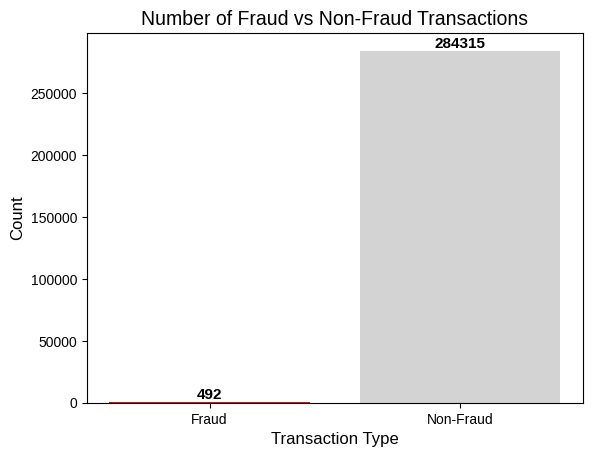

In [13]:
num_nonfraud = np.sum(data['Class'] == 0)
num_fraud = np.sum(data['Class'] == 1)

plt.bar(['Fraud', 'Non-Fraud'], [num_fraud, num_nonfraud], color=['red', 'lightgrey'])
plt.title('Number of Fraud vs Non-Fraud Transactions', fontsize=14)
plt.xlabel('Transaction Type', fontsize=12)
plt.ylabel('Count', fontsize=12)

# 막대 그래프 위에 수치 표시
for i, value in enumerate([num_fraud, num_nonfraud]):
    plt.text(i, value, str(value), ha='center', va='bottom', fontsize=11, fontweight='bold')

# 그래프 배경 스타일 설정
plt.style.use('seaborn-whitegrid')

plt.show()


In [14]:
data['Hour'] = data["Time"].apply(lambda x : divmod(x, 3600)[0])
X = data.drop(['Time','Class'],axis=1)
Y = data.Class

In [15]:
# 모델 훈련
iforest = IsolationForest()
# fit_predict 함수로 훈련 및 예측을 동시에 수행하여 모델에서의 이상치 여부를 판단합니다. -1은 이상치, 1은 정상을 의미합니다.
data['label'] = iforest.fit_predict(X)
# decision_function을 사용하여 예측을 통해 이상치 점수를 얻을 수 있습니다.
data['scores'] = iforest.decision_function(X)
# TopN 정확도 평가
n = 1000
df = data.sort_values(by='scores', ascending=True)
df = df.head(n)
rate = df[df['Class'] == 1].shape[0] / n
print('Top{}의 정확도는: {}'.format(n, rate))

Top1000의 정확도는: 0.137


> #### 정확도가 낮네요. 기본 파라미터가 무엇인지 확인해볼까요?

In [16]:
iforest.get_params()

{'bootstrap': False,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [18]:
# IsolationForest의 기본 매개변수는 다음과 같습니다:
# IsolationForest(n_estimators=100, contamination='auto', max_samples='auto', random_state=None)


* n_estimators: 사용할 결정 트리의 개수입니다. 기본값은 100입니다.
* contamination: 이상치로 간주할 비율을 나타냅니다. 기본값은 'auto'로 설정되어 데이터셋에서 자동으로 계산됩니다.
* max_samples: 각 결정 트리에 사용될 최대 샘플 수입니다. 기본값은 'auto'로 설정되어 데이터셋 크기에 기반하여 자동으로 계산됩니다.
* random_state: 난수 생성 시드입니다. 일관된 결과를 얻으려면 고정된 값을 사용할 수 있습니다. 기본값은 None으로 설정되어 난수가 매번 다르게 생성됩니다.

> #### 하이퍼파라미터 튜닝을 통해 모델 성능 개선이 가능한지 살펴보겠습니다.

정확도에 대한 `n_estimators`의 영향

`n_estimators`는 생성할 트리의 개수를 나타내는 매개변수로, 기본값은 100입니다. 우리는 10부터 500까지의 범위에서 테스트를 진행하여 어떤 범위에서 정확도가 향상되는지 살펴보겠습니다.

Top1000의 정확도: 0.114
Top1000의 정확도: 0.179
Top1000의 정확도: 0.18
Top1000의 정확도: 0.184
Top1000의 정확도: 0.178
Top1000의 정확도: 0.189
Top1000의 정확도: 0.194
Top1000의 정확도: 0.197
Top1000의 정확도: 0.185
Top1000의 정확도: 0.192
Top1000의 정확도: 0.189
Top1000의 정확도: 0.19
Top1000의 정확도: 0.193
Top1000의 정확도: 0.208
Top1000의 정확도: 0.207
Top1000의 정확도: 0.192
Top1000의 정확도: 0.197
Top1000의 정확도: 0.195
Top1000의 정확도: 0.197
Top1000의 정확도: 0.196
Top1000의 정확도: 0.202
Top1000의 정확도: 0.207
Top1000의 정확도: 0.207
Top1000의 정확도: 0.197
Top1000의 정확도: 0.195
Top1000의 정확도: 0.196
Top1000의 정확도: 0.192
Top1000의 정확도: 0.195
Top1000의 정확도: 0.191
Top1000의 정확도: 0.191
Top1000의 정확도: 0.191
Top1000의 정확도: 0.188
Top1000의 정확도: 0.183
Top1000의 정확도: 0.182
Top1000의 정확도: 0.183
Top1000의 정확도: 0.184
Top1000의 정확도: 0.185
Top1000의 정확도: 0.184
Top1000의 정확도: 0.184
Top1000의 정확도: 0.184
Top1000의 정확도: 0.183
Top1000의 정확도: 0.184
Top1000의 정확도: 0.183
Top1000의 정확도: 0.184
Top1000의 정확도: 0.183
Top1000의 정확도: 0.186
Top1000의 정확도: 0.185
Top1000의 정확도: 0.184
Top1000의 정확도: 0.185


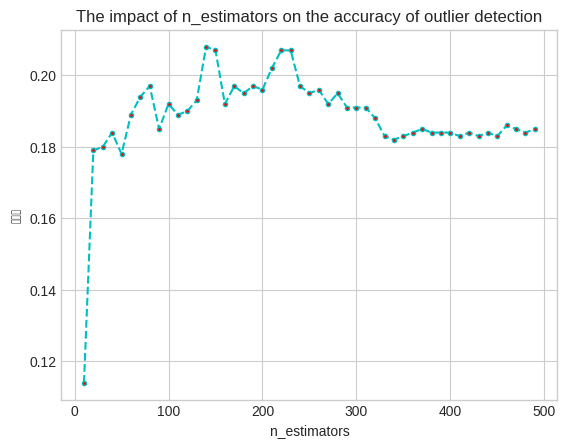

In [17]:
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')  # 경고 메시지 무시

n_est = list(range(10, 500, 10))
rates = []

for i in n_est:
    # 모델 훈련
    iforest = IsolationForest(n_estimators=i, 
                              max_samples=256,  
                              contamination=0.02, 
                              max_features=5,  
                              random_state=1
                              )
    # fit_predict 함수로 모델 훈련 및 예측
    data['label'] = iforest.fit_predict(X) 
    # decision_function으로 이상치 점수 예측
    data['scores'] = iforest.decision_function(X)  
    # TopN 정확도 평가
    n = 1000
    df = data.sort_values(by='scores', ascending=True)
    df = df.head(n)
    rate = df[df['Class']==1].shape[0] / n
    print('Top{}의 정확도: {}'.format(n, rate))
    rates.append(rate)

# 그래프 그리기
plt.style.use('seaborn-whitegrid')
plt.plot(n_est, rates, linestyle='--', marker='.', color='c', markerfacecolor='red')
plt.xlabel('n_estimators')
plt.ylabel('정확도')
plt.title('The impact of n_estimators on the accuracy of outlier detection')

# 그래프 표시
plt.show()


> 그림에서 볼 수 있듯이, 나무의 개수가 200을 초과하면 정확도가 감소하기 시작합니다. 약 300개의 나무에서는 상당히 낮은 수준에서 안정화되며 큰 개선이 나타나지 않습니다. 따라서, 나무의 개수가 많다고 해서 항상 더 좋은 성능을 보장하는 것은 아닙니다.

정확도에 대한 `max_features`의 영향

`max_features는`는 각 트리를 구성할 때 고려되는 특징의 개수를 의미합니다. 우리는 1부터 시작하여 데이터셋에 있는 총 30개의 특징까지 max_features의 영향을 평가합니다.

Top1000의 정확도는: 0.198
Top1000의 정확도는: 0.195
Top1000의 정확도는: 0.188
Top1000의 정확도는: 0.191
Top1000의 정확도는: 0.192
Top1000의 정확도는: 0.185
Top1000의 정확도는: 0.184
Top1000의 정확도는: 0.161
Top1000의 정확도는: 0.158
Top1000의 정확도는: 0.166
Top1000의 정확도는: 0.209
Top1000의 정확도는: 0.183
Top1000의 정확도는: 0.174
Top1000의 정확도는: 0.169
Top1000의 정확도는: 0.164
Top1000의 정확도는: 0.154
Top1000의 정확도는: 0.167
Top1000의 정확도는: 0.17
Top1000의 정확도는: 0.183
Top1000의 정확도는: 0.149
Top1000의 정확도는: 0.186
Top1000의 정확도는: 0.18
Top1000의 정확도는: 0.183
Top1000의 정확도는: 0.195
Top1000의 정확도는: 0.187
Top1000의 정확도는: 0.157
Top1000의 정확도는: 0.191
Top1000의 정확도는: 0.189
Top1000의 정확도는: 0.146
Top1000의 정확도는: 0.23
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[0.198, 0.195, 0.188, 0.191, 0.192, 0.185, 0.184, 0.161, 0.158, 0.166, 0.209, 0.183, 0.174, 0.169, 0.164, 0.154, 0.167, 0.17, 0.183, 0.149, 0.186, 0.18, 0.183, 0.195, 0.187, 0.157, 0.191, 0.189, 0.146, 0.23]


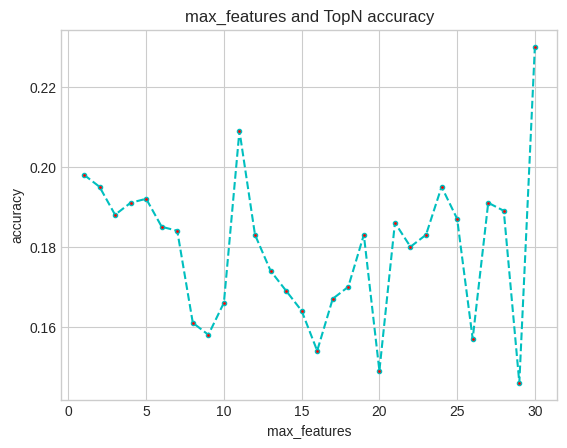

In [18]:
features = list(range(1, X.shape[1]+1))
rates = []
for i in features:
    # 모델 훈련
    iforest = IsolationForest(n_estimators=100,
                              max_samples=256,
                              contamination=0.02,
                              max_features=i,
                              random_state=1
                              )
    # fit_predict 함수로 훈련 및 예측을 동시에 수행하여 모델에서의 이상치 여부를 판단합니다. -1은 이상치, 1은 정상을 의미합니다.
    data['label'] = iforest.fit_predict(X)
    # decision_function을 사용하여 예측을 통해 이상치 점수를 얻을 수 있습니다.
    data['scores'] = iforest.decision_function(X)
    # Top-N 정확도 평가
    n = 1000
    df = data.sort_values(by='scores', ascending=True)
    df = df.head(n)
    rate = df[df['Class'] == 1].shape[0] / n
    print('Top{}의 정확도는: {}'.format(n, rate))
    rates.append(rate)

print(features)
print(rates)

import matplotlib.pyplot as plt
plt.plot(features, rates, linestyle='--', marker='.', color='c', markerfacecolor='red')
plt.title('max_features and TopN accuracy')
plt.xlabel('max_features')
plt.ylabel('accuracy')
plt.show()


> 볼 수 있듯이, 특성이 가장 많을 때 정확도가 가장 높습니다. 그러나 이론적으로 이는 크게 가능하지 않습니다. 랜덤 포레스트를 연구할 때 알 수 있듯이, 특성이 최대일 때 모델의 상관성이 매우 높아져, 통합 정확도가 오히려 떨어집니다. 그렇다면 왜 이런 상황이 발생하는 것일까요? 저는 매번 추출하는 샘플의 수가 너무 적기 때문이라고 추측합니다. 샘플 수를 늘려서 다시 살펴보겠습니다. max_samples = 1200

Top1000의 정확도는: 0.195
Top1000의 정확도는: 0.197
Top1000의 정확도는: 0.204
Top1000의 정확도는: 0.183
Top1000의 정확도는: 0.208
Top1000의 정확도는: 0.191
Top1000의 정확도는: 0.221
Top1000의 정확도는: 0.195
Top1000의 정확도는: 0.167
Top1000의 정확도는: 0.204
Top1000의 정확도는: 0.197
Top1000의 정확도는: 0.171
Top1000의 정확도는: 0.182
Top1000의 정확도는: 0.205
Top1000의 정확도는: 0.193
Top1000의 정확도는: 0.173
Top1000의 정확도는: 0.206
Top1000의 정확도는: 0.194
Top1000의 정확도는: 0.224
Top1000의 정확도는: 0.188
Top1000의 정확도는: 0.215
Top1000의 정확도는: 0.189
Top1000의 정확도는: 0.218
Top1000의 정확도는: 0.178
Top1000의 정확도는: 0.209
Top1000의 정확도는: 0.181
Top1000의 정확도는: 0.212
Top1000의 정확도는: 0.18
Top1000의 정확도는: 0.178
Top1000의 정확도는: 0.22
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[0.195, 0.197, 0.204, 0.183, 0.208, 0.191, 0.221, 0.195, 0.167, 0.204, 0.197, 0.171, 0.182, 0.205, 0.193, 0.173, 0.206, 0.194, 0.224, 0.188, 0.215, 0.189, 0.218, 0.178, 0.209, 0.181, 0.212, 0.18, 0.178, 0.22]


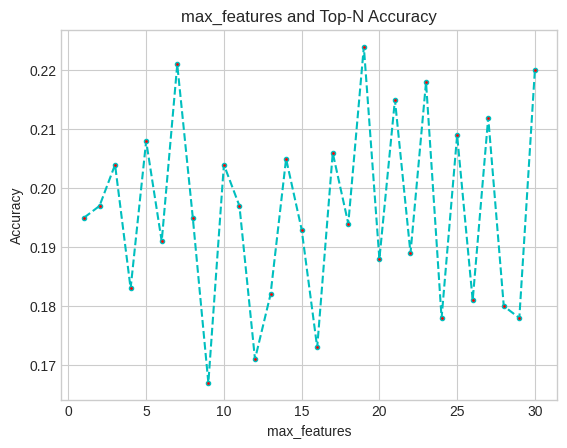

In [19]:
features = list(range(1, X.shape[1]+1))
rates = []

for i in features:
    # 모델 훈련
    iforest = IsolationForest(n_estimators=100,
                              max_samples=1200,
                              contamination=0.02,
                              max_features=i,
                              random_state=1
                              )
    # fit_predict 함수로 훈련 및 예측을 동시에 수행하여 모델에서의 이상치 여부를 판단합니다. -1은 이상치, 1은 정상을 의미합니다.
    data['label'] = iforest.fit_predict(X)
    # decision_function을 사용하여 예측을 통해 이상치 점수를 얻을 수 있습니다.
    data['scores'] = iforest.decision_function(X)
    # Top-N 정확도 평가
    n = 1000
    df = data.sort_values(by='scores', ascending=True)
    df = df.head(n)
    rate = df[df['Class'] == 1].shape[0] / n
    print('Top{}의 정확도는: {}'.format(n, rate))
    rates.append(rate)

print(features)
# [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

print(rates)
# [0.198, 0.195, 0.188, 0.191, 0.192, 0.185, 0.184, 0.161, 0.158, 0.166, 0.209, 0.183, 0.174, 0.169, 0.164, 0.154, 0.167, 0.17, 0.183, 0.149, 0.186, 0.18, 0.183, 0.195, 0.187, 0.157, 0.191, 0.189, 0.146, 0.23]

import matplotlib.pyplot as plt
plt.plot(features, rates, linestyle='--', marker='.', color='c', markerfacecolor='red')
plt.title('max_features and Top-N Accuracy')
plt.xlabel('max_features')
plt.ylabel('Accuracy')
plt.show()


우리가 볼 수 있듯이, 샘플 수를 늘릴수록 정확도와 max_features의 영향이 극단적이지 않습니다. 대략 7정도의 값에서 좋은 성능을 얻을 수 있습니다.

이로써 우리의 가설이 맞았음을 확인할 수 있으며, 계속해서 샘플 크기를 증가시켜 추가적인 테스트를 진행할 수 있습니다.

정확도에 대한 `max_samples`의 영향

`max_samples`는 각 샘플을 추출하는 개수를 나타내는 매개변수로, 기본값은 256입니다. 우리 데이터셋의 크기인 28만개의 샘플에 비교하면 매우 작은 수입니다. 그럼에도 불구하고, 이렇게 작은 수로도 매우 좋은 정확도를 얻을 수 있습니다.

이 매개변수는 가장 어려운 테스트 중 하나이며, 수천에서 수십만까지 수준의 변동이 포함됩니다. 우리는 작은 값부터 시작하여 기본값과 동일한 수준에서 정확도의 변화를 살펴보겠습니다.

Top1000의 정확도는:0.142
Top1000의 정확도는:0.115
Top1000의 정확도는:0.1
Top1000의 정확도는:0.127
Top1000의 정확도는:0.131
Top1000의 정확도는:0.164
Top1000의 정확도는:0.174
Top1000의 정확도는:0.18
Top1000의 정확도는:0.167
Top1000의 정확도는:0.169
Top1000의 정확도는:0.169
Top1000의 정확도는:0.171
Top1000의 정확도는:0.168
Top1000의 정확도는:0.179
Top1000의 정확도는:0.189
Top1000의 정확도는:0.192
Top1000의 정확도는:0.173
Top1000의 정확도는:0.177
Top1000의 정확도는:0.172
Top1000의 정확도는:0.167
Top1000의 정확도는:0.171
Top1000의 정확도는:0.17
Top1000의 정확도는:0.173
Top1000의 정확도는:0.185
Top1000의 정확도는:0.172
Top1000의 정확도는:0.174
Top1000의 정확도는:0.179
Top1000의 정확도는:0.165
Top1000의 정확도는:0.166
Top1000의 정확도는:0.183
Top1000의 정확도는:0.183
Top1000의 정확도는:0.165
Top1000의 정확도는:0.199
Top1000의 정확도는:0.201
Top1000의 정확도는:0.196
Top1000의 정확도는:0.191
Top1000의 정확도는:0.197
Top1000의 정확도는:0.19
Top1000의 정확도는:0.194
Top1000의 정확도는:0.198
Top1000의 정확도는:0.186
Top1000의 정확도는:0.187
Top1000의 정확도는:0.188
Top1000의 정확도는:0.186
Top1000의 정확도는:0.194
Top1000의 정확도는:0.185
Top1000의 정확도는:0.18
Top1000의 정확도는:0.187
Top1000의 정확도는:0.189
Top1000의 정확도는:0.202
Top100

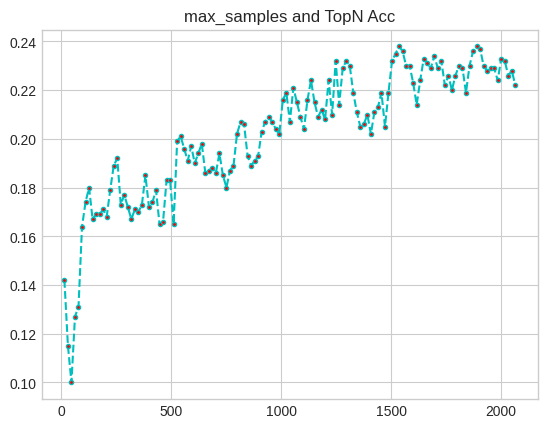

In [20]:
samples = list(range(16,2066,16))
rates = []
for i in samples:
    # 모델 훈련
    iforest = IsolationForest(n_estimators=100, 
                              max_samples= i,  
                              contamination=0.02, 
                              max_features=5,  
                              random_state=1
                              )
    # fit_predict 함수를 이용해 훈련과 예측을 함께 수행하며, -1은 이상치, 1은 정상치를 나타냄
    data['label'] = iforest.fit_predict(X) 
    # decision_function을 이용해 이상치 점수를 예측
    data['scores'] = iforest.decision_function(X)  
    # TopN 정확도 평가
    n = 1000
    df =  data.sort_values(by='scores',ascending=True)
    df = df.head(n)
    rate = df[df['Class']==1].shape[0]/n
    print('Top{}의 정확도는:{}'.format(n,rate))
    rates.append(rate)
    
import matplotlib.pyplot as plt
plt.plot(samples,rates, linestyle='--', marker='.',color='c',markerfacecolor='red')
plt.title('max_samples and TopN Acc')
plt.show()


이 코드는 Isolation Forest 모델을 이용하여 데이터의 이상치를 감지하고, 감지 결과에 대한 Top N 정확도를 평가하는 것입니다. 'max_samples' 매개변수의 변화에 따른 Top N 정확도의 변화를 시각화하여, 적절한 'max_samples' 값을 설정하는 데 도움을 주는 것이 목적입니다. 이상치 감지 알고리즘의 성능은 'max_samples' 값에 영향을 받을 수 있습니다.

계속 증가하는 것 같네요. 27만까지 더 늘려서 테스트해보겠습니다.

Top1000의 정확도:0.105
Top1000의 정확도:0.234
Top1000의 정확도:0.227
Top1000의 정확도:0.231
Top1000의 정확도:0.238
Top1000의 정확도:0.206
Top1000의 정확도:0.231
Top1000의 정확도:0.218
Top1000의 정확도:0.247
Top1000의 정확도:0.228
Top1000의 정확도:0.242
Top1000의 정확도:0.248
Top1000의 정확도:0.228
Top1000의 정확도:0.234
Top1000의 정확도:0.245
Top1000의 정확도:0.241
Top1000의 정확도:0.248
Top1000의 정확도:0.221
Top1000의 정확도:0.248
Top1000의 정확도:0.249
Top1000의 정확도:0.242
Top1000의 정확도:0.243
Top1000의 정확도:0.225
Top1000의 정확도:0.228
Top1000의 정확도:0.23
Top1000의 정확도:0.233
Top1000의 정확도:0.235
Top1000의 정확도:0.248
Top1000의 정확도:0.243
Top1000의 정확도:0.247
Top1000의 정확도:0.254
Top1000의 정확도:0.251
Top1000의 정확도:0.252
Top1000의 정확도:0.236
Top1000의 정확도:0.246
Top1000의 정확도:0.233
Top1000의 정확도:0.235
Top1000의 정확도:0.223
Top1000의 정확도:0.246
Top1000의 정확도:0.244
Top1000의 정확도:0.255
Top1000의 정확도:0.251
Top1000의 정확도:0.249
Top1000의 정확도:0.254
Top1000의 정확도:0.251
Top1000의 정확도:0.257
Top1000의 정확도:0.242
Top1000의 정확도:0.261
Top1000의 정확도:0.235
Top1000의 정확도:0.243
Top1000의 정확도:0.246
Top1000의 정확도:0.246
Top1000의 정확도:

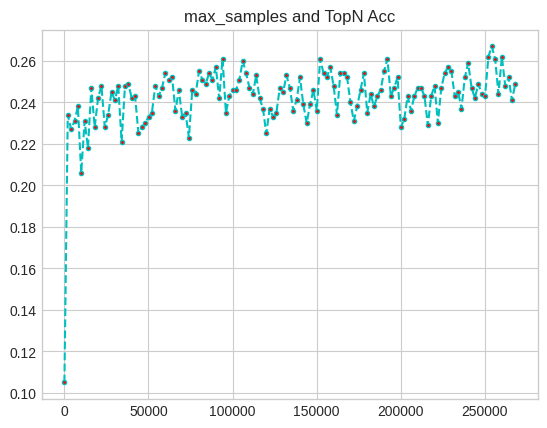

In [21]:
# 샘플 크기 범위를 정의합니다.
samples = list(range(50,270000,2000))
# 정확도를 저장할 빈 리스트를 생성합니다.
rates = []

# 각 샘플 크기에 대해 반복합니다.
for i in samples:
    # 모델을 학습시킵니다.
    iforest = IsolationForest(n_estimators=100, 
                              max_samples = i,  
                              contamination=0.02, 
                              max_features=5,  
                              random_state=1
                              )
    # fit_predict 함수를 사용하여 데이터를 학습하고 예측합니다. 이상치는 -1, 정상은 1로 표시됩니다.
    data['label'] = iforest.fit_predict(X) 
    # decision_function을 사용하여 이상치 점수를 계산합니다.
    data['scores'] = iforest.decision_function(X)  
    # TopN 정확도를 평가합니다.
    n = 1000
    # 점수가 낮은 순서대로 데이터를 정렬합니다.
    df =  data.sort_values(by='scores',ascending=True)
    # Top N 데이터를 선택합니다.
    df = df.head(n)
    # 선택된 데이터 중 이상치의 비율을 계산합니다.
    rate = df[df['Class']==1].shape[0]/n
    print('Top{}의 정확도:{}'.format(n,rate))
    # 정확도를 rates 리스트에 추가합니다.
    rates.append(rate)
    
# 결과를 그래프로 시각화합니다.
import matplotlib.pyplot as plt
plt.plot(samples,rates, linestyle='--', marker='.',color='c',markerfacecolor='red')
plt.title('max_samples and TopN Acc')
plt.show()


> ### final test

앞서 진행한 하이퍼 파라미터 튜닝 작업을 기반으로 하이퍼 파라미터를 선정해 최종 모델을 만들어 보겠습니다.

In [22]:
# 모델 훈련
iforest = IsolationForest(n_estimators=250, 
                          max_samples = 125000,  
                          contamination=0.05, 
                          max_features=5,  
                          random_state=1
                          )
# fit_predict 함수를 이용해 훈련과 예측을 함께 수행하며, -1은 이상치, 1은 정상치를 나타냄
data['label'] = iforest.fit_predict(X) 
# decision_function을 이용해 이상치 점수를 예측
data['scores'] = iforest.decision_function(X)  
# TopN 정확도 평가
n = 1000
df =  data.sort_values(by='scores',ascending=True)
df = df.head(n)
rate = df[df['Class']==1].shape[0]/n
print('Top{}의 정확도는:{}'.format(n,rate))
# 출력 결과: Top1000의 정확도는:0.251

# Top1000 데이터 저장
# df.to_csv('df.csv',header=True,index=False)


Top1000의 정확도는:0.251


> 이 코드는 Isolation Forest라는 이상치 탐지 모델을 이용하여 데이터의 이상치를 감지하고, 감지 결과에 대한 Top N 정확도를 평가하는 것입니다. 여기서 N은 1000입니다. 즉, 가장 높은 이상치 점수를 가진 상위 1000개의 데이터를 추출하고, 이 중에서 실제 이상치의 비율을 계산하여 모델의 정확도를 평가하는 것입니다. 그리고 마지막에는 Top 1000개의 데이터를 'df.csv' 파일로 저장합니다.

간단한 테스트 결과, 정확도가 18%에서 25%로 크게 향상되었습니다. 이는 상당한 개선이라고 볼 수 있습니다. 이상 탐지의 결과를 보면, 순위로 보면 매우 정확하다는 것을 알 수 있습니다. 따라서 비지도식 이상 탐지는 많은 가능성을 가지고 있습니다.